# Reranking Evaluation

Compare retrieval with and without reranking.

## Setup

In [1]:
# Add project root to path
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)

Project root: /home/al/Documents/rag-google-io


In [5]:
# Imports
import json
import numpy as np
from typing import List, Dict
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from qdrant_client import QdrantClient
from qdrant_client.models import Prefetch
from sentence_transformers import SentenceTransformer

from retrieval.rerankers.cross_encoder import CrossEncoderReranker

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Load Data and Models

In [6]:
# Load ground truth
with open("../data/eval/ground_truth_gpt5nano.json", "r") as f:
    ground_truth = json.load(f)

print(f"Loaded {len(ground_truth)} evaluation queries")

Loaded 10 evaluation queries


In [20]:
# Connect to Qdrant
q_client = QdrantClient(url="http://localhost:6333")
print(q_client.get_collections()) #check
DENSE_COLLECTION = "google-io-transcripts"
HYBRID_COLLECTION = "hybrid_collection"

# Load embedding model
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def embed_query(text: str):
    return embedding_model.encode(text).tolist()

collections=[CollectionDescription(name='sparse_collection'), CollectionDescription(name='google-io-transcripts'), CollectionDescription(name='hybrid_collection')]


In [9]:
# Initialize reranker
reranker = CrossEncoderReranker(model_name="cross-encoder/ms-marco-MiniLM-L-6-v2")
# Alternative models:
# reranker = CrossEncoderReranker("cross-encoder/ms-marco-TinyBERT-L-2-v2")  # Faster
# reranker = CrossEncoderReranker("BAAI/bge-reranker-base")  # Higher quality

Loading reranker model: cross-encoder/ms-marco-MiniLM-L-6-v2


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

## Retrieval Functions

In [26]:
def dense_retrieve(query, k=10):
    dense_vector = embed_query(query)

    response = q_client.query_points(
        collection_name=HYBRID_COLLECTION,
        query=dense_vector,
        using="dense",
        limit=k,
        with_payload=True,
    )

    return [
        {
            "id": p.payload["doc_id"],
            "score": p.score,
            "payload": p.payload,
        }
        for p in response.points
    ]

In [27]:
def retrieve_and_rerank(query: str, retrieve_k: int = 100, rerank_k: int = 10):
    """
    Two-stage retrieval:
    1. Retrieve top-N candidates
    2. Rerank and return top-K
    """
    # Stage 1: Retrieve candidates
    candidates = dense_retrieve(query, k=retrieve_k)
    
    if not candidates:
        return []
    
    # Stage 2: Rerank
    reranked = reranker.rerank(
        query=query,
        documents=candidates,
        top_k=rerank_k,
        return_scores=True
    )
    
    return reranked

## Evaluation Metrics

In [28]:
def recall_at_k(results: List[Dict], relevant_ids: List[str], k: int) -> int:
    """Binary recall: 1 if any relevant doc in top-k"""
    retrieved = [r["payload"]["doc_id"] for r in results[:k]]
    return int(any(rid in retrieved for rid in relevant_ids))

def mrr(results: List[Dict], relevant_ids: List[str]) -> float:
    """Mean Reciprocal Rank"""
    for i, r in enumerate(results, start=1):
        if r["payload"]["doc_id"] in relevant_ids:
            return 1.0 / i
    return 0.0

def precision_at_k(results: List[Dict], relevant_ids: List[str], k: int) -> float:
    """Proportion of retrieved docs that are relevant"""
    retrieved = [r["payload"]["doc_id"] for r in results[:k]]
    relevant_retrieved = sum(1 for rid in retrieved if rid in relevant_ids)
    return relevant_retrieved / k if k > 0 else 0.0

def average_precision(results: List[Dict], relevant_ids: List[str]) -> float:
    """Average Precision (AP)"""
    precisions = []
    num_relevant = 0
    
    for i, r in enumerate(results, start=1):
        if r["payload"]["doc_id"] in relevant_ids:
            num_relevant += 1
            precisions.append(num_relevant / i)
    
    return np.mean(precisions) if precisions else 0.0

## Run Evaluation

In [29]:
# Evaluate baseline (dense-only, top-10)
print("Evaluating baseline (dense-only)...")
baseline_results = {
    'recall@5': [],
    'recall@10': [],
    'mrr': [],
    'precision@5': [],
    'map': []
}

for item in tqdm(ground_truth):
    results = dense_retrieve(item["query"], k=10)
    relevant_ids = item["relevant_doc_ids"]
    
    baseline_results['recall@5'].append(recall_at_k(results, relevant_ids, 5))
    baseline_results['recall@10'].append(recall_at_k(results, relevant_ids, 10))
    baseline_results['mrr'].append(mrr(results, relevant_ids))
    baseline_results['precision@5'].append(precision_at_k(results, relevant_ids, 5))
    baseline_results['map'].append(average_precision(results, relevant_ids))

print("\nBaseline Results:")
for metric, values in baseline_results.items():
    print(f"  {metric}: {np.mean(values):.4f}")

Evaluating baseline (dense-only)...


100%|██████████████████████████████████████████████| 10/10 [00:01<00:00,  7.18it/s]


Baseline Results:
  recall@5: 0.8000
  recall@10: 0.9000
  mrr: 0.6393
  precision@5: 0.1600
  map: 0.6393


In [30]:
# Evaluate with reranking
print("\nEvaluating with reranking...")
rerank_results = {
    'recall@5': [],
    'recall@10': [],
    'mrr': [],
    'precision@5': [],
    'map': []
}

for item in tqdm(ground_truth):
    results = retrieve_and_rerank(
        item["query"], 
        retrieve_k=100,  # Retrieve more candidates
        rerank_k=10      # Rerank to top-10
    )
    relevant_ids = item["relevant_doc_ids"]
    
    rerank_results['recall@5'].append(recall_at_k(results, relevant_ids, 5))
    rerank_results['recall@10'].append(recall_at_k(results, relevant_ids, 10))
    rerank_results['mrr'].append(mrr(results, relevant_ids))
    rerank_results['precision@5'].append(precision_at_k(results, relevant_ids, 5))
    rerank_results['map'].append(average_precision(results, relevant_ids))

print("\nReranking Results:")
for metric, values in rerank_results.items():
    print(f"  {metric}: {np.mean(values):.4f}")


Evaluating with reranking...


100%|██████████████████████████████████████████████| 10/10 [00:52<00:00,  5.24s/it]


Reranking Results:
  recall@5: 1.0000
  recall@10: 1.0000
  mrr: 0.9333
  precision@5: 0.2000
  map: 0.9333


## Compare Results

In [31]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Metric': ['Recall@5', 'Recall@10', 'MRR', 'Precision@5', 'MAP'],
    'Baseline': [
        np.mean(baseline_results['recall@5']),
        np.mean(baseline_results['recall@10']),
        np.mean(baseline_results['mrr']),
        np.mean(baseline_results['precision@5']),
        np.mean(baseline_results['map'])
    ],
    'With Reranking': [
        np.mean(rerank_results['recall@5']),
        np.mean(rerank_results['recall@10']),
        np.mean(rerank_results['mrr']),
        np.mean(rerank_results['precision@5']),
        np.mean(rerank_results['map'])
    ]
})

comparison_df['Improvement'] = comparison_df['With Reranking'] - comparison_df['Baseline']
comparison_df['Improvement %'] = (comparison_df['Improvement'] / comparison_df['Baseline'] * 100).round(2)

print("\n" + "="*60)
print("COMPARISON: Baseline vs Reranking")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)


COMPARISON: Baseline vs Reranking
     Metric  Baseline  With Reranking  Improvement  Improvement %
   Recall@5  0.800000        1.000000     0.200000          25.00
  Recall@10  0.900000        1.000000     0.100000          11.11
        MRR  0.639286        0.933333     0.294048          46.00
Precision@5  0.160000        0.200000     0.040000          25.00
        MAP  0.639286        0.933333     0.294048          46.00


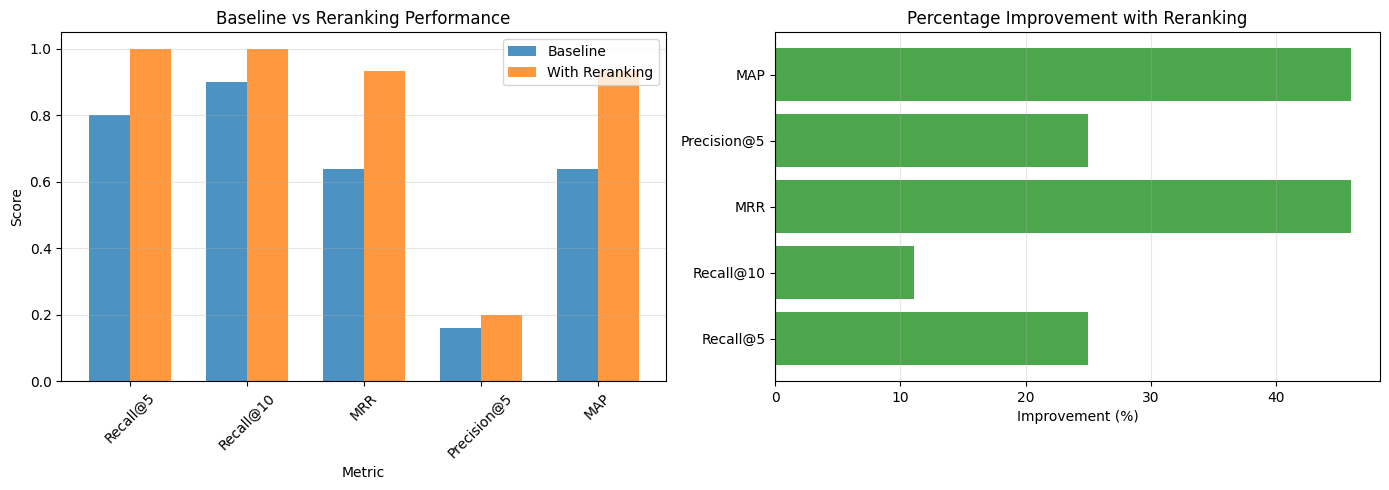

In [32]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart comparison
metrics = comparison_df['Metric'].tolist()
x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, comparison_df['Baseline'], width, label='Baseline', alpha=0.8)
axes[0].bar(x + width/2, comparison_df['With Reranking'], width, label='With Reranking', alpha=0.8)
axes[0].set_xlabel('Metric')
axes[0].set_ylabel('Score')
axes[0].set_title('Baseline vs Reranking Performance')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=45)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Improvement visualization
colors = ['green' if x > 0 else 'red' for x in comparison_df['Improvement']]
axes[1].barh(metrics, comparison_df['Improvement %'], color=colors, alpha=0.7)
axes[1].set_xlabel('Improvement (%)')
axes[1].set_title('Percentage Improvement with Reranking')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## Example Query Analysis

In [33]:
# Analyze a specific query
query_idx = 0
query = ground_truth[query_idx]["query"]
relevant_ids = ground_truth[query_idx]["relevant_doc_ids"]

print(f"Query: {query[:100]}...")
print(f"\nRelevant doc IDs: {relevant_ids}\n")

# Get baseline results
baseline = dense_retrieve(query, k=10)
print("=== BASELINE (Dense-only top-10) ===")
for i, r in enumerate(baseline, 1):
    is_relevant = "✓" if r["payload"]["doc_id"] in relevant_ids else "✗"
    print(f"{i}. {is_relevant} {r['payload']['doc_id']} (score: {r['score']:.4f})")

# Get reranked results
reranked = retrieve_and_rerank(query, retrieve_k=100, rerank_k=10)
print("\n=== WITH RERANKING (retrieve 100 → rerank to 10) ===")
for i, r in enumerate(reranked, 1):
    is_relevant = "✓" if r["payload"]["doc_id"] in relevant_ids else "✗"
    rerank_score = r.get('rerank_score', 0)
    print(f"{i}. {is_relevant} {r['payload']['doc_id']} (rerank: {rerank_score:.4f})")

Query: What were the main topics and components discussed in Google's AI Stack for Developers session at Go...

Relevant doc IDs: ['4TE-KFXvhAk__chunk_000']

=== BASELINE (Dense-only top-10) ===
1. ✓ 4TE-KFXvhAk__chunk_000 (score: 0.6397)
2. ✗ 4TE-KFXvhAk__chunk_017 (score: 0.5994)
3. ✗ 4TE-KFXvhAk__chunk_019 (score: 0.5812)
4. ✗ 4TE-KFXvhAk__chunk_001 (score: 0.5470)
5. ✗ gHHjDRDNUNU__chunk_007 (score: 0.5117)
6. ✗ 4TE-KFXvhAk__chunk_006 (score: 0.4782)
7. ✗ 4TE-KFXvhAk__chunk_003 (score: 0.4651)
8. ✗ Uh-7YX8tkxI__chunk_000 (score: 0.4489)
9. ✗ 4TE-KFXvhAk__chunk_007 (score: 0.4397)
10. ✗ o7Bv4r08FBM__chunk_000 (score: 0.4363)

=== WITH RERANKING (retrieve 100 → rerank to 10) ===
1. ✓ 4TE-KFXvhAk__chunk_000 (rerank: 4.5374)
2. ✗ 4TE-KFXvhAk__chunk_019 (rerank: 1.3136)
3. ✗ 4TE-KFXvhAk__chunk_017 (rerank: 0.8233)
4. ✗ 4TE-KFXvhAk__chunk_011 (rerank: -0.2629)
5. ✗ 4TE-KFXvhAk__chunk_010 (rerank: -0.3015)
6. ✗ 4TE-KFXvhAk__chunk_005 (rerank: -0.3748)
7. ✗ 4TE-KFXvhAk__chunk_001 (rerank: 

## Experiment: Different Retrieve-K Values

Testing different retrieve_k values...


100%|████████████████████████████████████████████████| 5/5 [02:32<00:00, 30.47s/it]


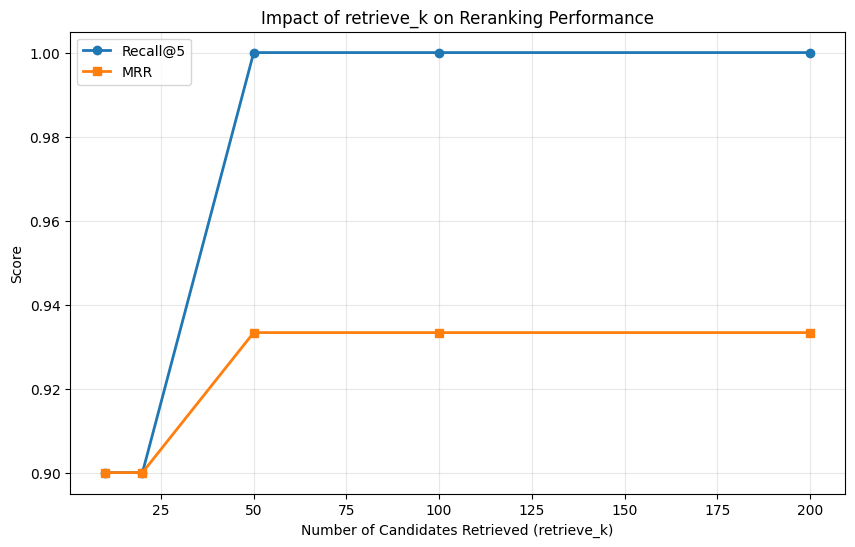


Results by retrieve_k:
  retrieve_k=10: Recall@5=0.9000, MRR=0.9000
  retrieve_k=20: Recall@5=0.9000, MRR=0.9000
  retrieve_k=50: Recall@5=1.0000, MRR=0.9333
  retrieve_k=100: Recall@5=1.0000, MRR=0.9333
  retrieve_k=200: Recall@5=1.0000, MRR=0.9333


In [34]:
# Test different numbers of candidates for reranking
retrieve_k_values = [10, 20, 50, 100, 200]
results_by_k = {}

print("Testing different retrieve_k values...")
for retrieve_k in tqdm(retrieve_k_values):
    recalls = []
    mrrs = []
    
    for item in ground_truth:
        results = retrieve_and_rerank(
            item["query"],
            retrieve_k=retrieve_k,
            rerank_k=10
        )
        relevant_ids = item["relevant_doc_ids"]
        
        recalls.append(recall_at_k(results, relevant_ids, 5))
        mrrs.append(mrr(results, relevant_ids))
    
    results_by_k[retrieve_k] = {
        'recall@5': np.mean(recalls),
        'mrr': np.mean(mrrs)
    }

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
k_values = list(results_by_k.keys())
recall_values = [results_by_k[k]['recall@5'] for k in k_values]
mrr_values = [results_by_k[k]['mrr'] for k in k_values]

ax.plot(k_values, recall_values, marker='o', label='Recall@5', linewidth=2)
ax.plot(k_values, mrr_values, marker='s', label='MRR', linewidth=2)
ax.set_xlabel('Number of Candidates Retrieved (retrieve_k)')
ax.set_ylabel('Score')
ax.set_title('Impact of retrieve_k on Reranking Performance')
ax.legend()
ax.grid(alpha=0.3)
plt.show()

print("\nResults by retrieve_k:")
for k, metrics in results_by_k.items():
    print(f"  retrieve_k={k}: Recall@5={metrics['recall@5']:.4f}, MRR={metrics['mrr']:.4f}")

## Save Results

In [35]:
# Save evaluation results
results_to_save = {
    'baseline': {metric: float(np.mean(values)) for metric, values in baseline_results.items()},
    'reranking': {metric: float(np.mean(values)) for metric, values in rerank_results.items()},
    'comparison': comparison_df.to_dict('records'),
    'retrieve_k_analysis': {str(k): v for k, v in results_by_k.items()}
}

with open("../data/eval/reranking_results.json", "w") as f:
    json.dump(results_to_save, f, indent=2)

print("\nResults saved to data/eval/reranking_results.json")


Results saved to data/eval/reranking_results.json
